In [2]:
#!pip install statsmodels==0.12.1
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.2 MB/s eta 0:00:0000:0100:01


In [2]:
import numpy as np
import pickle
import itertools
import joblib
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt

import statsmodels.api as sm
import statsmodels

import datetime
from datetime import timedelta
# from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.metrics import mean_squared_error
from pathlib import Path

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

Загрузим данные

In [4]:
data = pd.read_csv('electricity.txt')
data.head()

,Unnamed: 0,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
0,1,3853.475392,20.90,0,0,48
1,2,3683.014105,20.70,1,1,49
2,3,3912.324031,20.50,2,2,50
3,4,3783.881181,20.05,3,3,51
4,5,3554.257244,19.60,4,4,52


In [5]:
start = datetime.datetime(2000, 1, 10)
times = [start + timedelta(minutes = 30 * i) for i in range(0, 5520)]
data.set_index(pd.DatetimeIndex(times, freq="30min"), inplace=True)
data.drop(columns = ["Unnamed: 0"], inplace = True)
data.head()

,Consumption,Temperature,Time,DailySeasonality,WeeklySeasonality
2000-01-10 00:00:00,3853.475392,20.90,0,0,48
2000-01-10 00:30:00,3683.014105,20.70,1,1,49
2000-01-10 01:00:00,3912.324031,20.50,2,2,50
2000-01-10 01:30:00,3783.881181,20.05,3,3,51
2000-01-10 02:00:00,3554.257244,19.60,4,4,52


In [6]:
daily_data = 48
test_data = data[-daily_data*7:]
train_data = data[:-daily_data*7]

**1.** С помощью преобразований исходных рядов, о которых говорилось на первой лекции, приведите их к стационарным. Помочь в определении тренда и сезонности могут графики ACF и PACF. Проверьте, является ли ряд стационарным, с помощью KPSS.

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">`statsmodels.graphics.tsaplots.plot_acf`</a>`(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, **kwargs)`

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html">`statsmodels.graphics.tsaplots.plot_pacf`</a>`(x, ax=None, lags=None, alpha=0.05, method='ywm', use_vlines=True, title='Partial Autocorrelation', zero=True, **kwargs)`

* `x` &mdash; временной ряд;
* `lags` &mdash; набор лагов в виде списка или число &mdash; количество лагов (используется `np.arange(lags)`);
* `ax` &mdash; фигура `matplotlib`;
* `alpha` &mdash; уровень доверия для доверительных интервалов.

На графиках по горизонтальной оси изображены лаги. Синими точками отмечены значения функций, для наглядности рисуется также отрезок, соединяющий их с горизонтальной осью. Закрашенная область соответствует области незначимой корреляции. Все значения, лежащие вне закрашенной области признаются значимо отличными от нуля.

Не забываем также, что в нуле значение всегда равно 1 &mdash; корреляция случайной величины с самой собой.

**Совет:** Сначала сделайте ресеплинг данных по часам, для более быстрых вычислений в дальнейшем. Так как SARIMAX поддерживает только 1 сезонность, потому что чем длинее период сезонности, тем сильнее модель может переобучиться и будет дольше работать.

In [7]:
train_data = train_data.reset_index().groupby(pd.Grouper(key='index', freq='H')).sum().rename_axis('date')
test_data = test_data.reset_index().groupby(pd.Grouper(key='index', freq='H')).sum().rename_axis('date')

In [8]:
k = kpss(train_data.Consumption)[1]
j = "стационарным" if k > 0.05 else "не стационарным"
print(f"p-value KPSS: {round(k, 3)}, ряд является {j}")

p-value KPSS: 0.013, ряд является не стационарным


In [9]:
train_data['cons_s'] = train_data.Consumption - train_data.Consumption.shift(24*7)
train_data['cons_s'] = train_data['cons_s'] - train_data['cons_s'].shift(1)
k2 = kpss(train_data.cons_s[24*7+1:])[1]
j2 = "стационарным" if k2 > 0.05 else "не стационарным"
print(f"p-value KPSS: {round(k2, 3)}, ряд является {j2}")

p-value KPSS: 0.1, ряд является стационарным


**2.** По ACF и PACF подберите параметры модели $\text{SARIMA}(p, d, q) \times (P, D, Q)_s$.

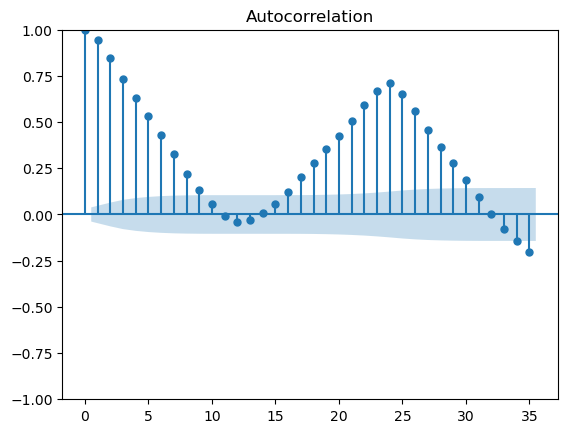

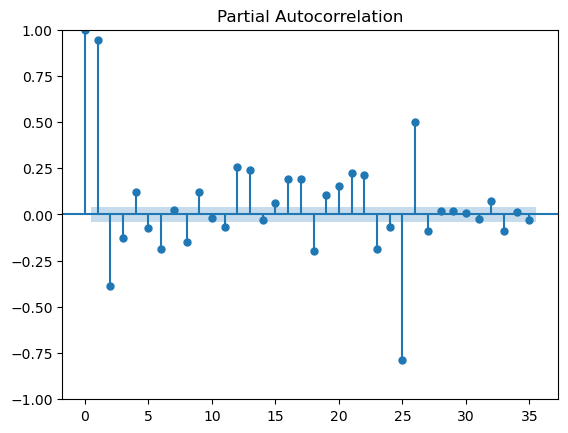

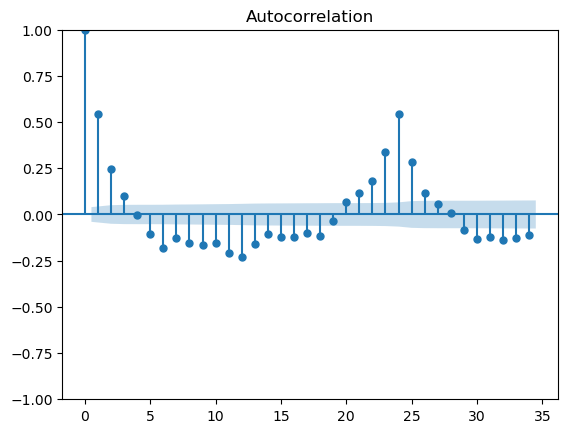

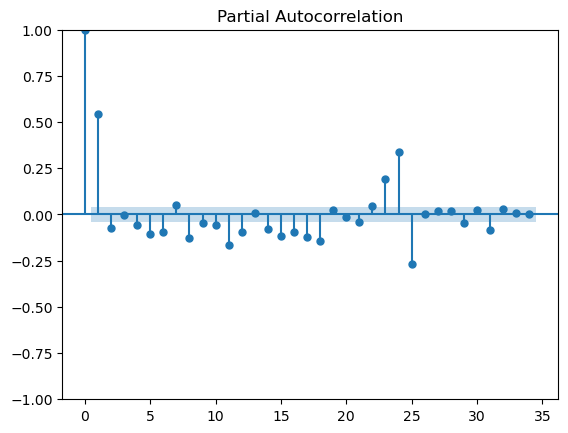

In [10]:
plot_acf(train_data.Consumption)
plot_pacf(train_data.Consumption)
plot_acf(train_data.cons_s[24*7+1:])
plot_pacf(train_data.cons_s[24*7+1:])
plt.show()

p - это последний значимый пик в PACF, а q - это последний значимый пик у PACF

**3.** С помощью поиска по сетке вокруг выбранных параметров подберите оптимальные параметры по значению AIC.

Класс, реализующий модель SARIMAX$(p, d, q) \times (P, D, Q)_s$

`class` <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">`statsmodels.tsa.statespace.sarimax.SARIMAX`</a>`(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, **kwargs)`

Параметры:

* `endog` &mdash; временной ряд;
* `exog` &mdash; экзогенные факторы (регрессоры);
* `order` = гиперпараметы $(p, d, q)$ модели ARIMA;
* `seasonal_order` = сезонные гиперпараметры $(P, D, Q, s)$
* `trend` &mdash; тренд по времени. Например, если `trend=[1,1,0,1]`, то модель содержит $a + bt + ct^3$. По умолчанию тренд не используется;
* `enforce_stationarity` &mdash; требовать ли стационарность AR компоненты. Если нет, то AR-составляющая модели может задавать нестационарный ряд. Если да, то модель может не подобраться;
* `enforce_invertibility ` &mdash; требовать ли обратимость MA компоненты.

Атрибуты построенной модели:

* `polynomial_ar` &mdash; коэффициенты AR-составляющей;
* `polynomial_ma` &mdash; коэффициенты MA-составляющей;
* `polynomial_seasonal_ar` &mdash; коэффициенты сезонной AR-составляющей;
* `polynomial_seasonal_ma` &mdash; коэффициенты сезонной MA-составляющей;
* `polynomial_trend` &mdash; коэффициенты тренда по времени;
* и другие.

In [13]:
%%time
mod = SARIMAX(train_data.cons_s[24*7:], order=(1, 1, 3), seasonal_order=(1, 1, 1, 24), simple_differencing=True)
res=mod.fit(disp=0)

CPU times: user 53.8 s, sys: 2min 19s, total: 3min 13s
Wall time: 12.2 s


In [12]:
%%time
mod = SARIMAX(train_data.cons_s[24*7:], order=(1, 1, 3), seasonal_order=(1, 1, 1, 24), simple_differencing=True)
res=mod.fit(disp=0)

CPU times: user 5min 2s, sys: 7min 22s, total: 12min 25s
Wall time: 31.4 s


In [13]:
p = range(1, 4)
q = range(1, 4)
P = range(1, 4)
Q = range(1, 4)

from itertools import product
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

81

In [14]:
result = []
from tqdm import tqdm
for param in tqdm(parameters_list):
    model=SARIMAX(train_data.cons_s[24*7+1:], order=(param[0], 1, param[1]), 
                  seasonal_order=(param[2], 1, param[3], 24), simple_differencing=True).fit(disp=0)
    result.append([param, model.aic])

100%|█████████████████████████████████████████| 81/81 [2:00:06<00:00, 88.97s/it]


In [ ]:
result = []
from tqdm import tqdm
for param in tqdm(parameters_list):
    model=SARIMAX(train_data.cons_s[24*7+1:], order=(param[0], 1, param[1]), 
                  seasonal_order=(param[2], 1, param[3], 24), simple_differencing=True).fit(disp=0)
    result.append([param, model.aic])

 14%|█▎        | 11/81 [22:11<2:18:35, 118.80s/it]

In [17]:
pd.DataFrame(result).sort_values(1)

,0,1
8,"(1, 1, 3, 3)",31359.544231
17,"(1, 2, 3, 3)",31385.852430
59,"(3, 1, 2, 3)",31463.995938
79,"(3, 3, 3, 2)",31465.830134
32,"(2, 1, 2, 3)",31496.817550
...,...,...
65,"(3, 2, 1, 3)",31627.608768
47,"(2, 3, 1, 3)",31629.111174
2,"(1, 1, 1, 3)",31635.414924
62,"(3, 1, 3, 3)",31667.155659


**4.** Постройте прогнозы модели с оптимальными параметрами на неделю вперед.
Посчитайте качество прогноза по сравнению с реальными данными на тестовом интервале, используя метрику MSE.

Получить предсказания среднего и доверительного интервала у уже обученной модели можно так:


```
pred_dynamic = model.get_forecast(steps = <num_steps>, dynamic=True)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()
```

Для красивой визуализации предсказаний можно переиспользовать такой шаблон:


```
ax = y[<start_index>:].plot(label='observed', figsize=(15, 6), lw=1)
pred_mean.plot(label='Dynamic Forecast', ax=ax, lw=2, color='red')
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], \
                pred_dynamic_ci.iloc[:, 1], \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(<start_test_period_index>), y.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylim(<отображаемый интервал значений>))
ax.set_ylabel(<название предсказываемого поля>)
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()
```



In [16]:
%%time
model=SARIMAX(train_data.cons_s[24*7+1:], order=(1, 1, 1), seasonal_order=(3, 1, 3, 24), simple_differencing=True).fit(disp=0)
pred_dynamic = model.get_forecast(steps = 24*7, dynamic=True)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()

CPU times: user 15min 49s, sys: 19min 31s, total: 35min 20s
Wall time: 2min 15s


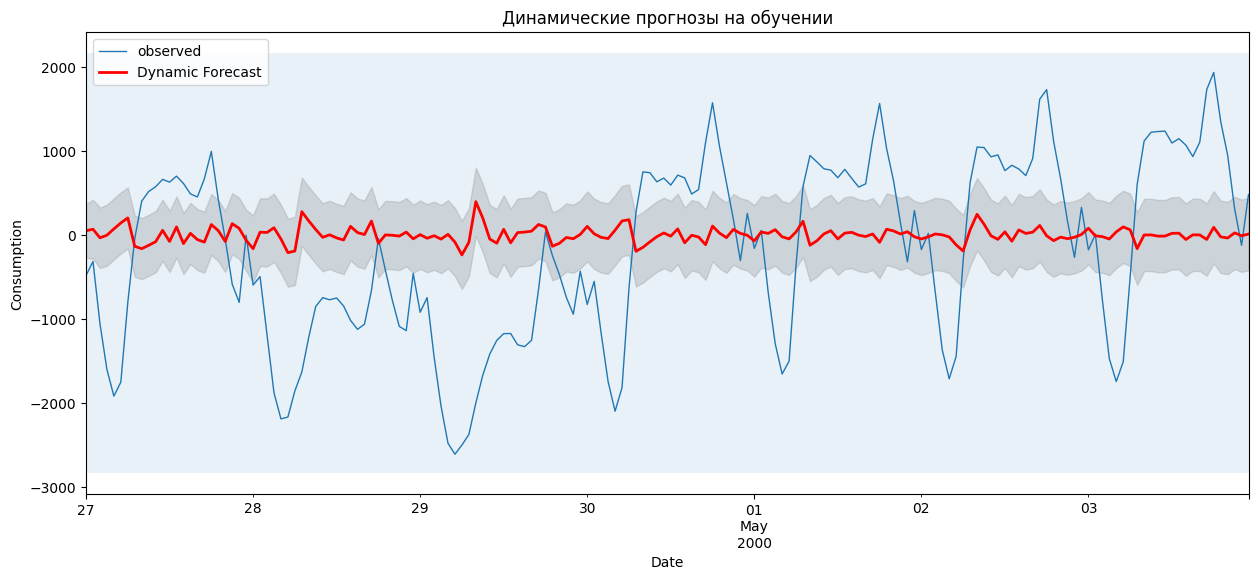

In [18]:
ax = (test_data.Consumption - train_data.Consumption[-1]).plot(label='observed', figsize=(15, 6), lw=1)
pred_mean.plot(label='Dynamic Forecast', ax=ax, lw=2, color='red')
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], \
                pred_dynamic_ci.iloc[:, 1], \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(test_data.index[0]), test_data.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

In [19]:
mean_squared_error(test_data.Consumption - train_data.Consumption[-1], pred_mean)

1191142.7942836664

**5.** Добавьте в модель предсказания электричества экзогенные факторы. Сделайте выводы, стала ли модель лучше в каждом из рассмотренных ниже случаев?

Добавлять экзогенные факторы нужно при инициализации модели и в методе `get_forecast` с помощью передачи параметра `exog=...`.

**5.1** 
- Значения температуры, используя на тестовом интервале времени истинные значения температуры (*нечестный способ*).

In [20]:
model=SARIMAX(train_data.cons_s[24*7+1:], order=(1, 1, 1), seasonal_order=(3, 1, 3, 24), simple_differencing=True, 
              exog=train_data.Temperature[24*7+1:]).fit(disp=0)

In [21]:
pred_dynamic = model.get_forecast(steps = 24*7, dynamic=True, exog=test_data.Temperature)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()

In [22]:
mean_squared_error(test_data.Consumption - train_data.Consumption[-1], pred_mean)

1190278.4081820366

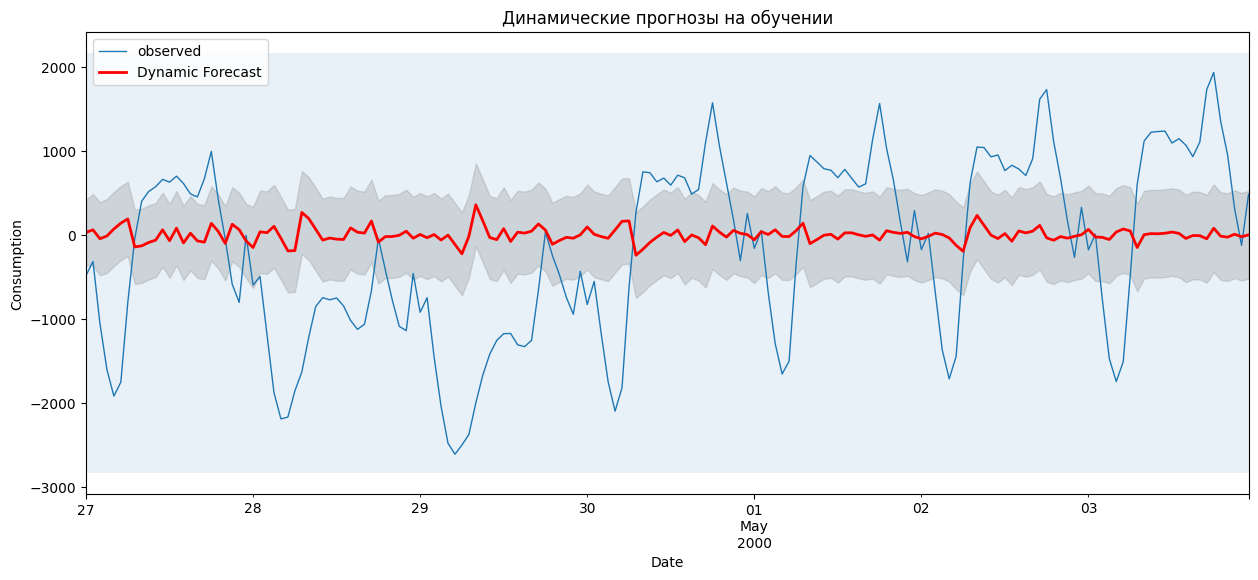

In [23]:
ax = (test_data.Consumption - train_data.Consumption[-1]).plot(label='observed', figsize=(15, 6), lw=1)
pred_mean.plot(label='Dynamic Forecast', ax=ax, lw=2, color='red')
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], \
                pred_dynamic_ci.iloc[:, 1], \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(test_data.index[0]), test_data.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

**5.2**
- Значения температуры, используя на тестовом интервале времени предсказания значений температуры. Предсказания можно получить с помощью модели Хольта-Уинтерса или `auto_arima` (подробнее об `auto_arima` написано в пункте **6.**).

In [24]:
%%time
temp_preds = ExponentialSmoothing(train_data.Temperature, trend='multiplicative', 
                                  damped_trend=True, seasonal='multiplicative', 
                                  seasonal_periods=24).fit(smoothing_level=0.7).forecast(len(test_data))
model=SARIMAX(train_data.cons_s[24*7+1:], order=(1, 1, 1), seasonal_order=(3, 1, 3, 24), simple_differencing=True, 
              exog=train_data.Temperature[24*7+1:]).fit(disp=0)
pred_dynamic = model.get_forecast(steps = 24*7, dynamic=True, exog=temp_preds)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()
mean_squared_error(test_data.Consumption - train_data.Consumption[-1], pred_mean)

/home/ivan/dev_venv/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


CPU times: user 19min 35s, sys: 26min 33s, total: 46min 8s
Wall time: 3min


1187476.2577791219

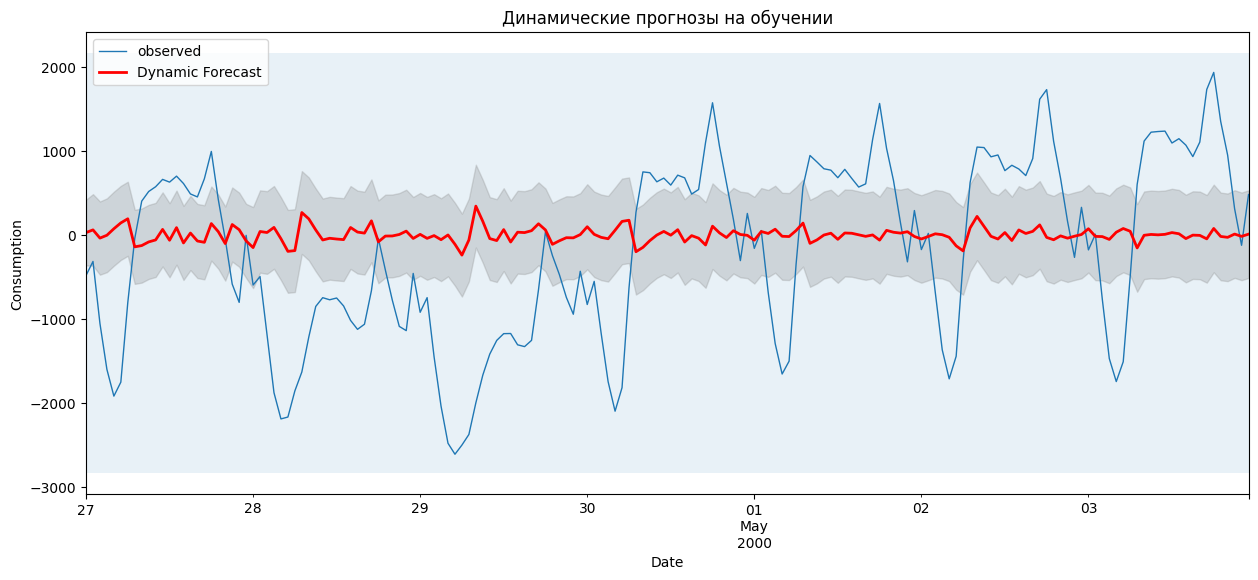

In [25]:
ax = (test_data.Consumption - train_data.Consumption[-1]).plot(label='observed', figsize=(15, 6), lw=1)
pred_mean.plot(label='Dynamic Forecast', ax=ax, lw=2, color='red')
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], \
                pred_dynamic_ci.iloc[:, 1], \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(test_data.index[0]), test_data.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

**5.3**
- Использование значений температуры по частям &mdash; для получения прогноза $\widehat{y}_{T+h|T}$ строится своя модель по временному ряду $y_{h}, ..., y_T$ со сдвинутым влево рядом экзогенного фактора $x_{1}, ..., x_{T-h}$. Тогда для получения прогноза $\widehat{y}_{T+h|T}$ нужно знать значения $x_{T-h+1}, ..., x_{T}$, которые известны на момент построения модели.

In [30]:
%%time

import warnings
warnings.filterwarnings("ignore")

x_preds, x_train = [], list(train_data.Temperature)
for _ in range(24*7):
    x_preds.append(ExponentialSmoothing(x_train, trend='multiplicative', damped_trend=True, seasonal='multiplicative', 
                                        seasonal_periods=24).fit(smoothing_level=0.7).forecast(1))
    x_train.append(x_preds[-1])

CPU times: user 1min 47s, sys: 0 ns, total: 1min 47s
Wall time: 1min 47s


In [31]:
%%time
model=SARIMAX(train_data.cons_s[24*7+1:], order=(1, 1, 1), seasonal_order=(3, 1, 3, 24), simple_differencing=True, 
              exog=train_data.Temperature[24*7+1:]).fit(disp=0)
pred_dynamic = model.get_forecast(steps = 24*7, dynamic=True, exog=x_preds)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()
mean_squared_error(test_data.Consumption - train_data.Consumption[-1], pred_mean)

CPU times: user 19min 42s, sys: 26min 32s, total: 46min 15s
Wall time: 2min 59s


1187476.2581426774

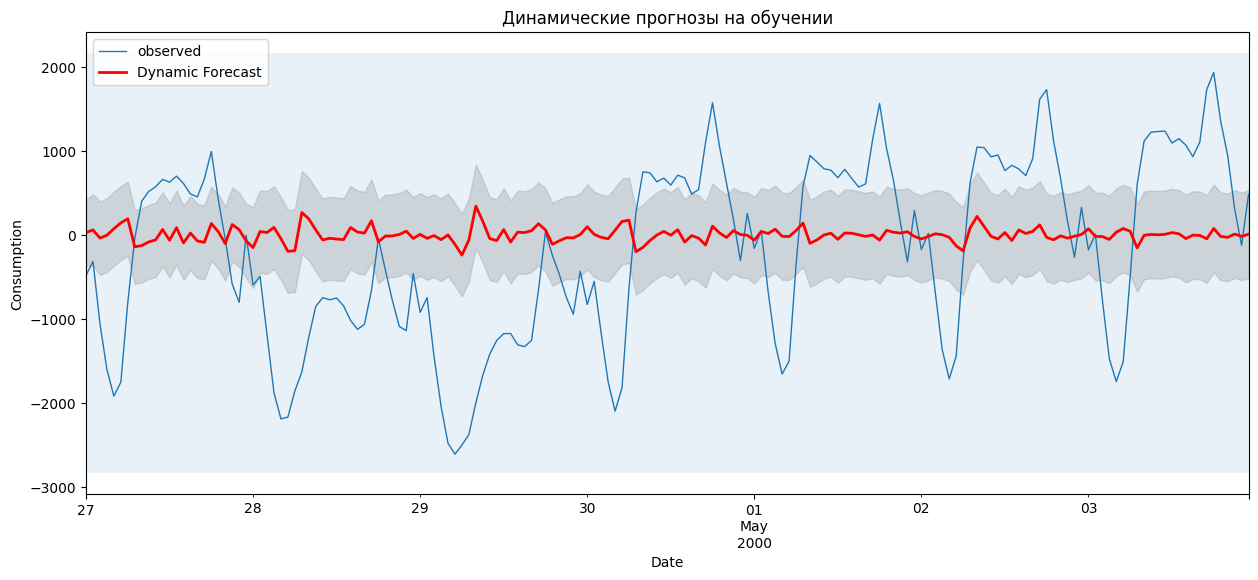

In [32]:
ax = (test_data.Consumption - train_data.Consumption[-1]).plot(label='observed', figsize=(15, 6), lw=1)
pred_mean.plot(label='Dynamic Forecast', ax=ax, lw=2, color='red')
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], \
                pred_dynamic_ci.iloc[:, 1], \
                color='grey', alpha=0.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(test_data.index[0]), test_data.index[-1], alpha=0.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

**6.** Постройте предсказания временного ряда для электричества, используя функцию `auto_arima` в Python, не совершая никаких преобразований ряда и не передавая в функцию никаких дополнительных параметров (кроме периода сезонности).

Класс, реализующий модель Auto Arima $(p, d, q) \times (P, D, Q)_s$, а именно &mdash; перебор параметров.

`class` <a href="https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima#pmdarima.arima.auto_arima">`pmdarima.arima.auto_arima`</a>`(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)`

Параметры:

* `y` &mdash; временной ряд;
* `X` &mdash; экзогенные факторы (регрессоры);
* `start_p=2, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, start_Q=1, max_P=2, max_D=1, max_Q=2, ` &mdash; гиперпараметы для перебора;
* `m` &mdash; сезонность;
* `maxiter` &mdash; максимальное количество оценок функций.

In [33]:
%%time
arima = auto_arima(y=train_data.Consumption, X=np.array(train_data.Temperature).reshape(-1, 1),
                   start_p=2, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, start_Q=1, max_P=2, max_D=1, max_Q=2, m=24)

CPU times: user 42min 45s, sys: 1h 46min 13s, total: 2h 28min 59s
Wall time: 10min 33s


In [34]:
arima.to_dict()

{'pvalues': intercept    6.214671e-01
 x1           1.844573e-12
 ar.L1        1.426968e-79
 ma.L1        1.882135e-11
 ar.S.L24     0.000000e+00
 sigma2       0.000000e+00
 dtype: float64,
 'resid': date
 2000-01-10 00:00:00    7107.983775
 2000-01-10 01:00:00    -712.052605
 2000-01-10 02:00:00    -699.989284
 2000-01-10 03:00:00      17.290732
 2000-01-10 04:00:00     324.353950
                           ...     
 2000-04-26 19:00:00       8.135596
 2000-04-26 20:00:00     -58.007734
 2000-04-26 21:00:00     -83.661845
 2000-04-26 22:00:00      53.109066
 2000-04-26 23:00:00      52.171864
 Freq: H, Length: 2592, dtype: float64,
 'order': (1, 1, 1),
 'seasonal_order': (1, 0, 0, 24),
 'oob': nan,
 'aic': 34143.23066254007,
 'aicc': 34143.263157704474,
 'bic': 34178.38945762344,
 'bse': intercept      3.881795
 x1             1.609553
 ar.L1          0.022320
 ma.L1          0.030749
 ar.S.L24       0.006339
 sigma2       412.190019
 dtype: float64,
 'params': intercept       -1.9167

In [35]:
%%time
arima_preds = arima.fit(y=train_data.Consumption, X=np.array(train_data.Temperature).reshape(-1, 1))

CPU times: user 1min 40s, sys: 4min 17s, total: 5min 57s
Wall time: 23.6 s


In [36]:
arima_preds=arima_preds.predict(n_periods=len(temp_preds), X=np.array(test_data.Temperature).reshape(-1, 1))

In [37]:
mean_squared_error(test_data.Consumption, arima_preds)

1388254.5025937303

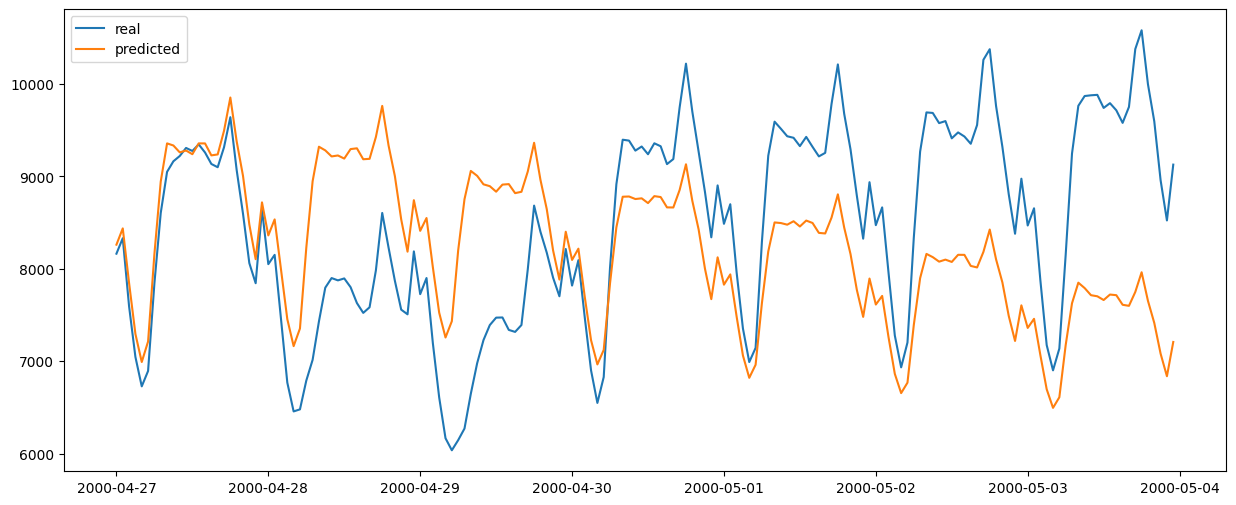

In [38]:
plt.figure(figsize=(15, 6));
plt.plot(test_data.Consumption, label='real');
plt.plot(pd.DataFrame(arima_preds, index=test_data.index), label='predicted');
plt.legend();

**7.** Сравните все предсказания от SARIMAX моделей и от моделей экспоненциального сглаживания по метрике MSE. Какую реализацию из рассмотренных вы выберете в будущем для предсказания временных рядов?

Наиболее близкими к реальности получились ExponentialSmoothing или auto_arima из рассмотренных моделей.В будущем для предсказания временных рядов я бы выбрал их.